In [11]:
import os
import torchvision
import pandas as pd
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from PIL import Image, ImageDraw
from torchvision.transforms import ToPILImage
from imports import create_model, plate_model, CCPDDataset
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import crop
from torchvision.io import read_image

In [12]:
provinces = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏",
             "浙", "京", "闽", "赣", "鲁", "豫", "鄂", "湘", "粤", "桂", "琼",
             "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "警", "学",
             "O"]
alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N',
             'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'O']
ads = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P',
       'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '0', '1', '2', '3', '4',
       '5', '6', '7', '8', '9', 'O']
BREAKS = [0, 
len(provinces),
len(provinces)+len(alphabets),
len(provinces)+len(alphabets)+1*len(ads),
len(provinces)+len(alphabets)+2*len(ads),
len(provinces)+len(alphabets)+3*len(ads),
len(provinces)+len(alphabets)+4*len(ads),
len(provinces)+len(alphabets)+5*len(ads)]

In [13]:
device = torch.device('cuda')
dataset = CCPDDataset('val.csv')
model1 = create_model(2, True).to(device)
model1.eval()
model2 = plate_model(True).to(device)
model2.eval()
torch.set_grad_enabled(False)

In [14]:
def random_test(verbose=True):
    # get random test item
    r = int(torch.randint(len(dataset), (1,)))
    out = dataset[r]
    image = out[0]
    real_box = out[1]['boxes'][0].tolist()
    real_plate_ints = out[1]['labels'].tolist()
    # pass through model1
    output = model1(out[0].unsqueeze(dim=0).to(device))[0]
    if not output['labels'].numel():
        if verbose:
            print("No plates found")
            display(ToPILImage()(image).resize((720//2, 1160//2)))
        return False
    if verbose:
        print('Scores:', output['scores'])
    box = output['boxes'][0:1]
    top = round(box[0,1].item())
    left = round(box[0,0].item())
    height = round(box[0,3].item() - top)
    width = round(box[0,2].item() - left)
    if verbose:
        print(box[0].round().type(torch.int).tolist())
        print(real_box)
    plate_image = crop(image, top, left, height, width).unsqueeze(dim=0)
    logits = model2(torchvision.transforms.Resize((256, 256))(plate_image).to(device))[0]
    plate = ''
    real_plate = ''
    for i in range(7):
        if i==0:
            plate += provinces[logits[BREAKS[i]:BREAKS[i+1]].argmax()]
            real_plate += provinces[real_plate_ints[i]]
        if i==1:
            plate += alphabets[logits[BREAKS[i]:BREAKS[i+1]].argmax()]
            real_plate += alphabets[real_plate_ints[i]]
        else:
            plate += ads[logits[BREAKS[i]:BREAKS[i+1]].argmax()]
            real_plate += ads[real_plate_ints[i]]
    if verbose:
        print(plate)
        print(real_plate)
        img = image.mul(255).type(torch.uint8)
        display(ToPILImage()(draw_bounding_boxes(img, box, [plate[1:]], colors='green', width=4)).resize((720//2, 1160//2)))
    return plate==real_plate

Scores: tensor([0.9988, 0.1240, 0.1016, 0.0750], device='cuda:0')
[333, 497, 518, 566]
[331, 497, 521, 567]
皖ALU1179
皖ALU1179


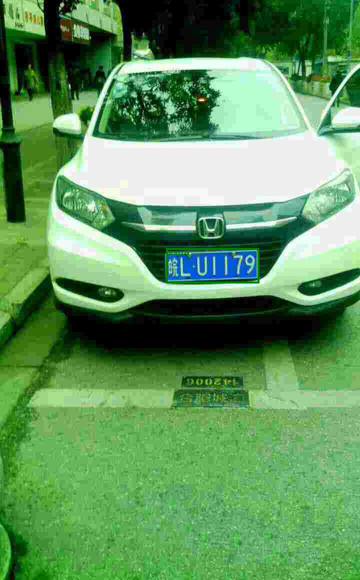

True

In [24]:
random_test(True)